# Belastingen uit RWS

#  importeer de benodigde functies

In [1]:
from pathlib import Path

import numpy as np

from toolbox_continu_inzicht import Config, datetime_from_epoch


## 1. Voorbeeld met CSV
Lees de configuratie in:

Dit leest een configuratie bestand `belasting_fews_config.yaml` in. 
```yaml
GlobalVariables:
    rootdir: "data_sets" 
    moments: [-24,0,24,48]  

    csv:
        delimiter: ","

    BelastingWaterwebservicesRWS:
        MISSING_VALUE: 999999999.0 

DataAdapter: 
    locaties: 
        type: csv
        path: "belastingen_rws.csv"
    waterstanden: 
        type: csv
        path: "waterstanden.csv"
...

```

In [2]:
test_data_sets_path = Path.cwd() / "data_sets"
c = Config(config_path=test_data_sets_path / "belasting_rws_config.yaml")
c.lees_config()

Zet de data adapter klaar en geef deze de configuratie mee 

In [3]:
from toolbox_continu_inzicht import DataAdapter

data = DataAdapter(config=c)

Run de module met CSV

In [4]:
from toolbox_continu_inzicht.belastingen import BelastingWaterwebservicesRWS

RWS_webservice = BelastingWaterwebservicesRWS(
    data_adapter=data, input="BelastingLocaties", output="Waterstanden"
)

In [5]:
lst_data = await RWS_webservice.run()

In [6]:
RWS_webservice.df_in

,index,measuringstationid
0,0,9405
1,1,8420
2,2,8411
3,3,9928


In [7]:
df_out = RWS_webservice.df_out.copy()

In [8]:
df_out

,objectid,objecttype,parameterid,datetime,value,calculating
0,8420,measuringstation,1,1.729237e+12,999999999.0,True
1,8420,measuringstation,1,1.729237e+12,999999999.0,True
2,8420,measuringstation,1,1.729238e+12,999999999.0,True
3,8420,measuringstation,1,1.729238e+12,119.0,True
4,8420,measuringstation,2,1.729239e+12,119.0,True
...,...,...,...,...,...,...
1295,9928,measuringstation,1,1.729237e+12,1744.0,True
1296,9928,measuringstation,1,1.729238e+12,1745.0,True
1297,9928,measuringstation,1,1.729238e+12,1744.0,True
1298,9928,measuringstation,2,1.729239e+12,1745.0,True


In [9]:
values_nan = df_out[df_out["value"] == 999999999.0].index
for val in values_nan:
    df_out.loc[val, "value"] = np.nan
df_plot = df_out.set_index(df_out["datetime"].apply(lambda x: datetime_from_epoch(x)))

<Axes: xlabel='datetime'>

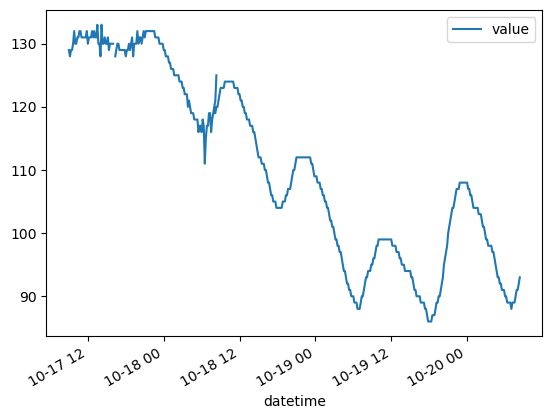

In [10]:
df_plot[df_plot["objectid"] == 8420][["value"]].plot()